# Multi-label classifier with CelebA dataset

Let us first get aquainted with the dataset. The [original website](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) tells the following: 
```
CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,

- 202,599 number of face images, and

- 5 landmark locations, 40 binary attributes annotations per image.
```

We may notice a high number of samples available, suggesting that usage of a deep network may be efficient. <br>
As for now, I have decided to use relatively modern ResNet-50 architecture, [introduced](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) by microsoft in 2015. Usage of residual blocks is essential for creating a very deep NN, as it helps to leverage vanishing gradient problem, typical for such architectures.<br>
I am also looking to further enchance the architecture by employing SE Blocks, a more recent technique [developed](https://openaccess.thecvf.com/content_cvpr_2018/papers/Hu_Squeeze-and-Excitation_Networks_CVPR_2018_paper.pdf) in 2018.

## Imports

In [4]:
import os
import csv
import time
import torch
import torchvision
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from torchvision import transforms
from torch.utils.data import DataLoader

## Constants

In [2]:
BATCH_SIZE = 64
NUM_WORKERS = 20

## Data preparation

In [3]:
# Check device
device = torch.device('cuda') if torch.cuda.is_available() else None
print(f'Using device: {device} | {torch.cuda.get_device_name()}')

Using device: cuda | NVIDIA GeForce RTX 3060 Ti


Since I was unable to find any normalization numbers for CelebA on the internet, I had to calculate them myself.
```python
compute_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CelebA(root='./data', split='train', transform=compute_transform)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)

from tqdm import tqdm

def calculate_mean_std(loader):
    n_channels = 3
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    # Wrap the loader in tqdm for a progress bar
    for images, _ in tqdm(loader, desc="Calculating mean and std"):
        batch_size, channels, height, width = images.shape
        total_pixels += batch_size * height * width

        # Sum and sum of squares
        mean += images.sum([0, 2, 3])
        std += (images ** 2).sum([0, 2, 3])

    mean /= total_pixels
    std = (std / total_pixels - mean ** 2).sqrt()

    return mean, std

mean, std = calculate_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")
```

The output:
```
Calculating mean and std: 100%|██████████| 1272/1272 [00:35<00:00, 36.15it/s]
Mean: tensor([0.5310, 0.4254, 0.3712])
Std: tensor([0.2981, 0.2675, 0.2618])
```

Now we can proceed with transformations and data loading. <br>
We are scaling and then cropping images to 224x224 size to ensure compliance with ResNet.

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5310, 0.4254, 0.3712),
                         (0.2981, 0.2675, 0.2618)),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5310, 0.4254, 0.3712),
                         (0.2981, 0.2675, 0.2618)),
])

In [5]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train', transform=train_transform, download=False)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test', transform=val_test_transform, download=False)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid', transform=val_test_transform, download=False)

In [6]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Now, something intresting happens.

In [7]:
print(len(train_dataset.attr_names), len(test_dataset.attr_names), len(valid_dataset.attr_names))
print(train_dataset.attr_names[37:], test_dataset.attr_names[37:], valid_dataset.attr_names[37:])

41 41 41
['Wearing_Necklace', 'Wearing_Necktie', 'Young', ''] ['Wearing_Necklace', 'Wearing_Necktie', 'Young', ''] ['Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


The following section did not appear to be useful, as I was getting dimension mismatch on training. Somehow my custom custom wrapper produces 38 attributes, though I could definetely see 40.
Those 41 phantom attributes in training somehow squeze to 40. No idea on what is going on here, but whatever...

----

We can see that an extra empty string attribute is present in the dataset, totaling attribute count to 41. This is not expected, and I will try to remove the empty string attribute. <br>
For this purpose, I will have to define a wrapper class.

```python
class CelebAMultiLabel(torchvision.datasets.CelebA):
    def __init__(self, root, split, transform=None, target_transform=None, download=False):
        super(CelebAMultiLabel, self).__init__(
            root=root,
            split=split,
            target_type='attr',
            transform=transform,
            target_transform=target_transform,
            download=download
        )
        # Exclude the last attribute
        self.attr = self.attr[:, :-1]
        self.attr_names = self.attr_names[:-1]
    
    def __getitem__(self, index):
        img, target = super(CelebAMultiLabel, self).__getitem__(index)
        # Exclude the last attribute
        target = target[:-1]
        return img, target

train_dataset = CelebAMultiLabel(root='./data', split='train', transform=train_transform, download=False)
test_dataset = CelebAMultiLabel(root='./data', split='test', transform=val_test_transform, download=False)
valid_dataset = CelebAMultiLabel(root='./data', split='valid', transform=val_test_transform, download=False)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Number of attributes per image: {len(train_dataset.attr_names)}")
print(f"Attribute Names: {train_dataset.attr_names}")
```
Output:
```
Number of attributes per image: 40
Attribute Names: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
```

Now that attibutes are correct, we can proceed to implementing ResNet-50 model architecture.

---
This is the end of unused section.

## ResNet-50

### Bottleneck block

PyTorch's [resnet](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py) implementation and some articles suggest that usage of Bottleneck blocks is essential for larger models (ResNet 50, 101, 152), as they dramatically improve learning speeds. This is achieved by applying dimension reduction with convolusion kernel 1x1 before time-consuming 3x3 convolusion, and then expanding back with 1x1 conv.

In [8]:
class Bottleneck(nn.Module):
    expansion = 4  # Expansion factor for output channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels before expansion
            stride (int): Stride for the convolution
            downsample (nn.Module or None): Downsampling layer to match dimensions
        """
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # To match dimensions if needed
        self.stride = stride

    def forward(self, x):
        identity = x  # Save input for residual connection

        # First convolution: dimenson reduction
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second convolution: feature extraction
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Third convolution: dimension restoration
        out = self.conv3(out)
        out = self.bn3(out)

        # Downsample if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Residual connection
        out += identity
        out = self.relu(out)

        return out

![](./img/bottleneck.svg)

### ResNet Architecture

Now to implement model's architecture. I will use PyTorch sources and [original article](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

The article suggests the following architecture:

![](./img/resnet_arch.png)

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=40):
        """
        Args:
            block (nn.Module): Block type (we use Bottleneck)
            layers (list): Number of blocks in each of the four layers
            num_classes (int): Number of output classes
        """
        super(ResNet, self).__init__()
        self.in_channels = 64  # Initial number of channels

        # Initial convolution and max pooling layers
        self.conv1 =   nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 =     nn.BatchNorm2d(self.in_channels)
        self.relu =    nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # The four layers of ResNet
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc =      nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Create one layer of the network consisting of multiple blocks.

        Args:
            block (nn.Module): Block type (we use Bottleneck)
            out_channels (int): Number of output channels before expansion
            blocks (int): Number of blocks in this layer
            stride (int): Stride for the first block in this layer
        """
        downsample = None
        # If the input and output dimensions differ, define a downsampling layer
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # First block in the layer may have stride and downsampling
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion  # Update in_channels for next blocks

        # Add remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """
        Initialize weights using Kaiming He initialization for convolutions
        and setting BatchNorm weights to 1 and biases to 0.
        """

        # I will not claim that I fully understand how the math behind this works
        # To me, this is just 'a good thing to do' for now
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution and max pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Transform to 2D tensor
        x = self.fc(x)

        return x


In [10]:
def ResNet50(num_classes=40):
    """
    Constructs a ResNet-50 model.

    Args:
        num_classes (int): Number of output classes

    Returns:
        ResNet: ResNet-50 model instance
    """
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)


In [11]:
# Instantiate the model
model = ResNet50(num_classes=40).to(device)

# Print model architecture
print(model)
print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

![](./img/resnet.svg)

Looks like a cool model to me.. Well, now to train it.

btw, I crafted the illustrations by myself, hope you like them

## Training ResNet-50

In [12]:
# Ensure reproducibility
torch.manual_seed(42)

In [13]:
# Define paths for checkpoints and logs
CHECKPOINT_PATH = 'checkpoints'
LOG_PATH = 'training_log.csv'
FULL_MODEL_PATH = 'resnet50_full_model.pth'

# Training and early stopping
NUM_EPOCHS = 50
PATIENCE = 10

# Variables for training
best_val_loss = float('inf')
epochs_no_improve = 0
start_epoch = 0

In [14]:
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [15]:
# Initialize logging
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, mode='w', newline='') as log_file:
        log_writer = csv.writer(log_file)
        log_writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Learning Rate', 'Elapsed Time'])

### Some troubles

The following configuration was used originally:
```python
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,            # Factor by which the learning rate will be reduced
    patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
    threshold=1e-4,
    threshold_mode='rel',
    cooldown=0,
    min_lr=1e-0,
)
```

I had to terminate training on 17th epoch, as I was no seeing significant improvements. 
Here is the log for 3 last epochs:
```
Epoch 14/50
----------
                                                             
Training Loss: 0.2696
                                                             
Validation Loss: 0.2510
Validation Metrics - Accuracy: 0.0110, Precision: 0.7477, Recall: 0.5048, F1 Score: 0.5273, AUC: 0.9094
Current Learning Rate: 0.100000
Elapsed Time: 670.61 seconds
No improvement in validation loss for 4 epoch(s).

Epoch 15/50
----------
                                                             
Training Loss: 0.2694
                                                             
Validation Loss: 0.2446
Validation Metrics - Accuracy: 0.0110, Precision: 0.7627, Recall: 0.4859, F1 Score: 0.5384, AUC: 0.9086
Current Learning Rate: 0.100000
Elapsed Time: 670.66 seconds
No improvement in validation loss for 5 epoch(s).

Epoch 16/50
----------
                                                             
Training Loss: 0.2692
                                                             
Validation Loss: 0.2450
Validation Metrics - Accuracy: 0.0130, Precision: 0.7313, Recall: 0.5153, F1 Score: 0.5514, AUC: 0.9106
Current Learning Rate: 0.010000
Elapsed Time: 670.66 seconds
No improvement in validation loss for 6 epoch(s).
```

We can observe that scheduler reduced learning rate, however no significant improvement was present. To support my observations, I will plot the training log.

In [2]:
def plot_metrics(file_path: str):
    training_log_df = pd.read_csv(file_path)

    epochs = training_log_df['Epoch']
    train_loss = training_log_df['Train Loss']
    val_loss = training_log_df['Val Loss']
    accuracy = training_log_df['Accuracy']
    precision = training_log_df['Precision']
    recall = training_log_df['Recall']
    f1_score = training_log_df['F1 Score']
    auc = training_log_df['AUC']

    # Plot Train Loss and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, label='Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.grid()
    plt.show()

    # Plot Precision, Recall, and F1 Score
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, precision, label='Precision', marker='o')
    plt.plot(epochs, recall, label='Recall', marker='o')
    plt.plot(epochs, f1_score, label='F1 Score', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score per Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot AUC
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, auc, label='AUC', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC per Epoch')
    plt.grid()
    plt.show()

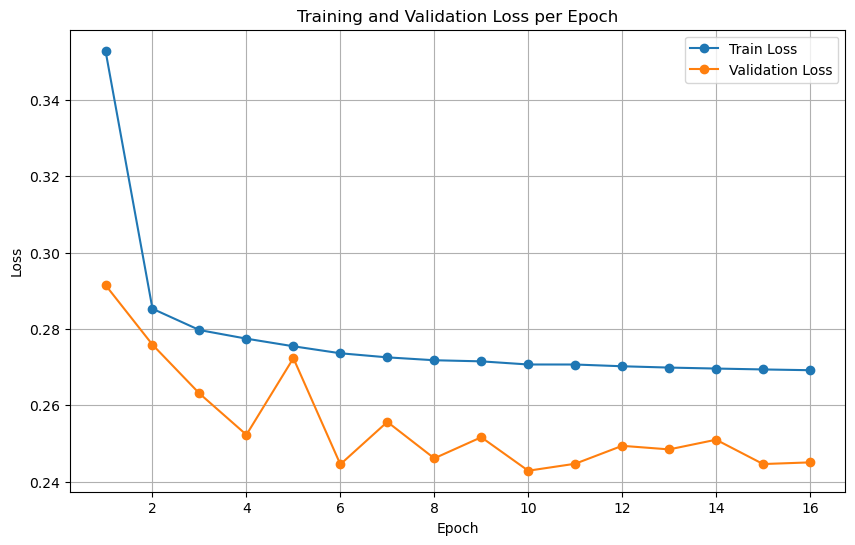

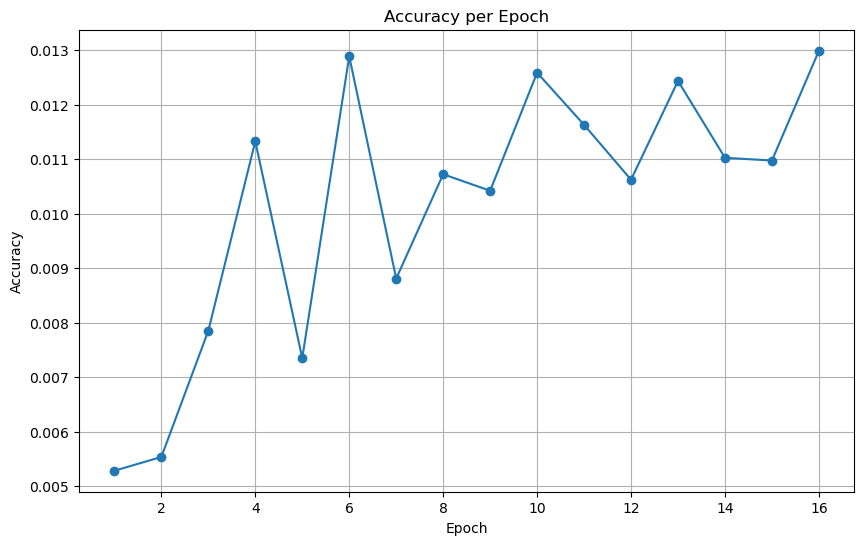

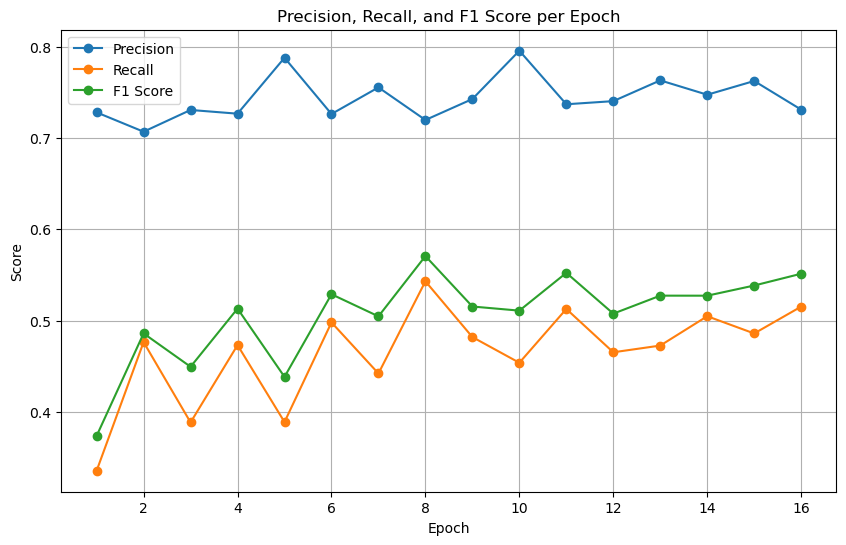

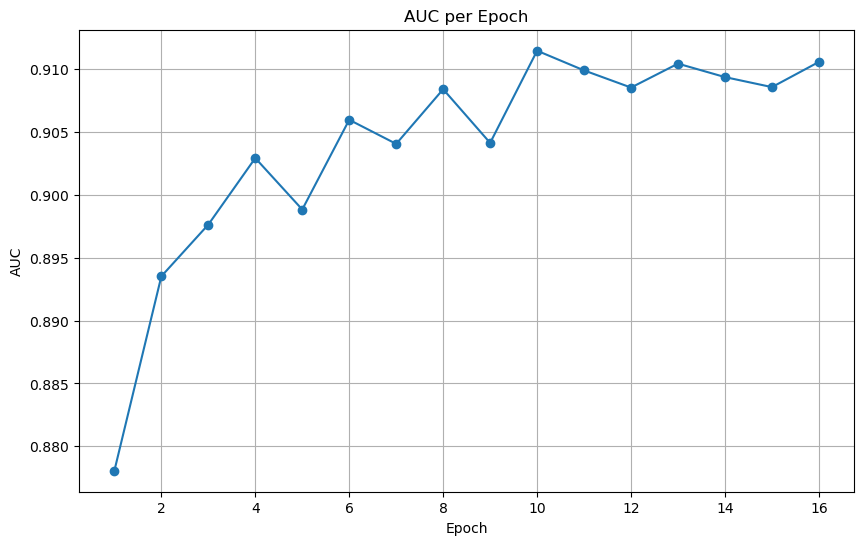

In [6]:
plot_metrics(file_path='./logs/sgd_reduce_on_plateau/sgd_reduce_on_plateau.csv')

### New config

As we can see, train loss nearly no decrease from 4th to 16th epoch, which is not expected. ReduceLROnPlateau scheduler does not seem to really help here. <br>
I have decided to use another scheduler and optimizer:

In [17]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,   
    weight_decay=5e-4
)

# Cosine Annealing Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS
)

In [18]:
def calculate_metrics(outputs, targets):
    # Apply sigmoid to outputs
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

    # Move to CPU and convert to numpy
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    probs = probs.cpu().detach().numpy()

    # Calculate metrics for multi-label classification
    accuracy = metrics.accuracy_score(targets, preds)
    precision = metrics.precision_score(targets, preds, average='macro', zero_division=0)
    recall = metrics.recall_score(targets, preds, average='macro', zero_division=0)
    f1 = metrics.f1_score(targets, preds, average='macro', zero_division=0)
    # AUC requires at least one positive and one negative sample per class
    try:
        auc = metrics.roc_auc_score(targets, probs, average='macro')
    except ValueError:
        auc = float('nan')

    return accuracy, precision, recall, f1, auc

In [19]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    return start_epoch, best_val_loss

In [20]:
# Check if a checkpoint exists
latest_checkpoint = None
if os.listdir(CHECKPOINT_PATH):
    checkpoints = sorted([ckpt for ckpt in os.listdir(CHECKPOINT_PATH) if ckpt.endswith('.pth')], key=lambda x: os.path.getmtime(os.path.join(CHECKPOINT_PATH, x)))
    latest_checkpoint = os.path.join(CHECKPOINT_PATH, checkpoints[-1])

if latest_checkpoint:
    print(f"Loading checkpoint from {latest_checkpoint}")
    start_epoch, best_val_loss = load_checkpoint(latest_checkpoint)
    print(f"Resuming from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

No checkpoint found. Starting training from scratch.


In [21]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        targets = targets.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_outputs.append(outputs)
        all_targets.append(targets)

    epoch_loss = running_loss / len(dataloader.dataset)
    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    return epoch_loss, all_outputs, all_targets

In [22]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            targets = targets.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            all_outputs.append(outputs)
            all_targets.append(targets)

    epoch_loss = running_loss / len(dataloader.dataset)
    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    return epoch_loss, all_outputs, all_targets

In [7]:
# Main training loop
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 10)
    epoch_start_time = time.time()

    # Training phase
    train_loss, train_outputs, train_targets = train(model, train_loader, criterion, optimizer, device)
    print(f"Training Loss: {train_loss:.4f}")

    # Validation phase
    val_loss, val_outputs, val_targets = validate(model, valid_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")

    # Calculate metrics
    accuracy, precision, recall, f1, auc = calculate_metrics(val_outputs, val_targets)
    print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

    # Step the scheduler
    scheduler.step()

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f"Current Learning Rate: {current_lr:.6f}")

    # Calculate elapsed time
    elapsed_time = time.time() - epoch_start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    # Log to CSV
    with open(LOG_PATH, mode='a', newline='') as log_file:
        log_writer = csv.writer(log_file)
        log_writer.writerow([epoch + 1, train_loss, val_loss, accuracy, precision, recall, f1, auc, current_lr, elapsed_time])

    # Checkpointing: Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        checkpoint_filename = os.path.join(CHECKPOINT_PATH, f'checkpoint_epoch_{epoch + 1}.pth')
        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_filename)
        print("Best model updated and checkpoint saved.\n")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).\n")

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
        break

# Save the full model after successful training
torch.save(model, FULL_MODEL_PATH)
print(f"Full model saved to {FULL_MODEL_PATH}")


NameError: name 'start_epoch' is not defined

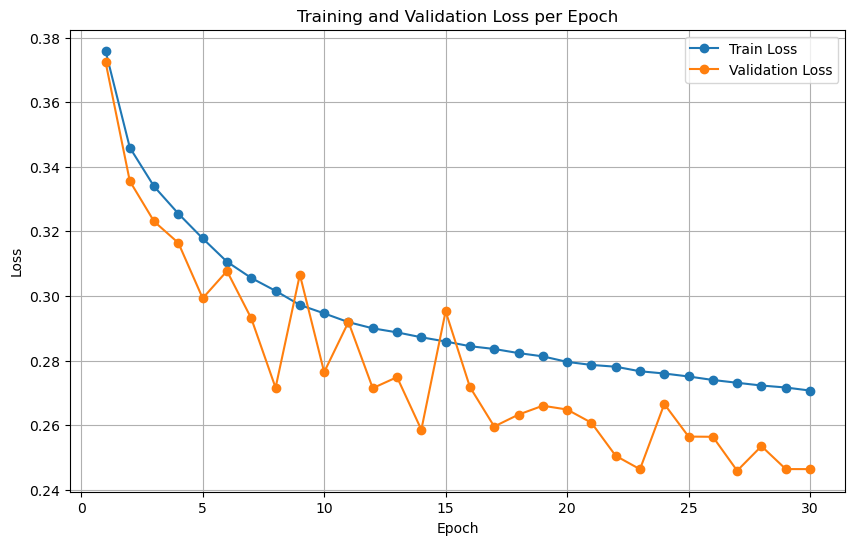

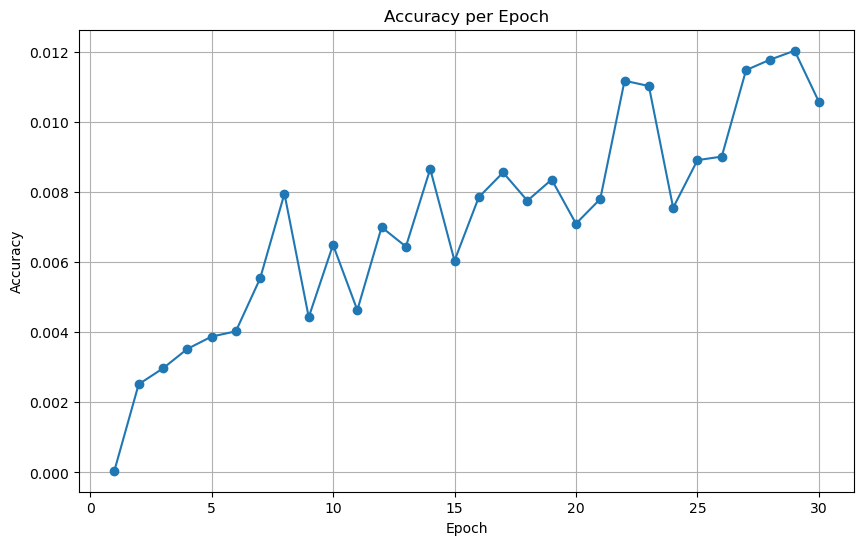

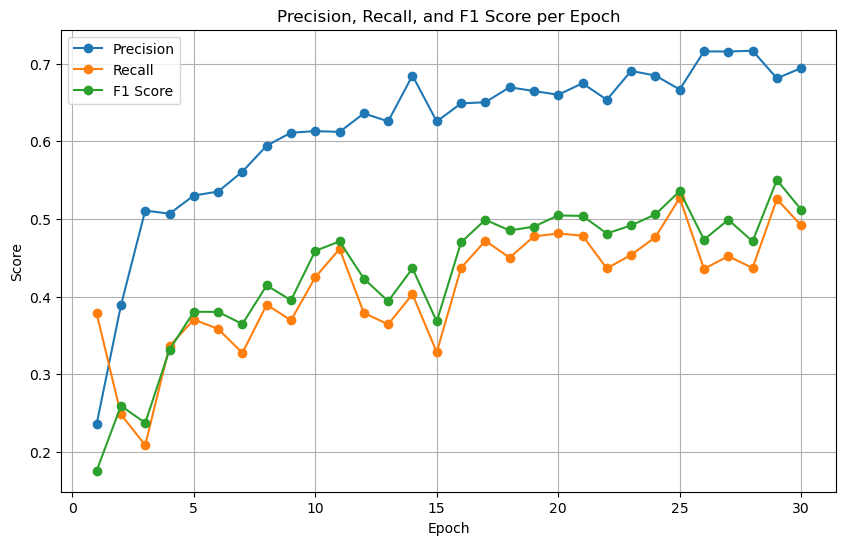

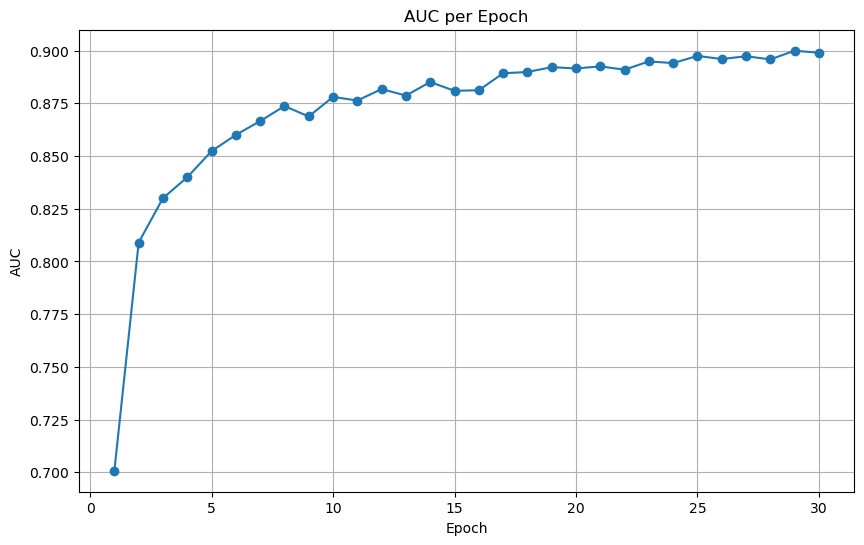

In [8]:
plot_metrics(file_path='./logs/adam_cosine/adam_cosine.csv')

After 30 epochs with Adam optimizer and Cosine Annealing optimizer, we can observe better learning curve and convergence.

In [13]:
def plot_metrics_two_files(file_path1: str, file_path2: str, label1: str = 'File 1', label2: str = 'File 2'):
    training_log_df1 = pd.read_csv(file_path1)
    training_log_df2 = pd.read_csv(file_path2)

    epochs1 = training_log_df1['Epoch']
    train_loss1 = training_log_df1['Train Loss']
    val_loss1 = training_log_df1['Val Loss']
    
    epochs2 = training_log_df2['Epoch']
    train_loss2 = training_log_df2['Train Loss']
    val_loss2 = training_log_df2['Val Loss']
    
    plt.figure(figsize=(12, 7))
    
    # File 1 - Train Loss
    plt.plot(epochs1, train_loss1, label=f'Train Loss - {label1}', marker='o', linestyle='-')
    
    # File 1 - Validation Loss
    plt.plot(epochs1, val_loss1, label=f'Validation Loss - {label1}', marker='o', linestyle='--')
    
    # File 2 - Train Loss
    plt.plot(epochs2, train_loss2, label=f'Train Loss - {label2}', marker='s', linestyle='-')
    
    # File 2 - Validation Loss
    plt.plot(epochs2, val_loss2, label=f'Validation Loss - {label2}', marker='s', linestyle='--')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch for Two Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

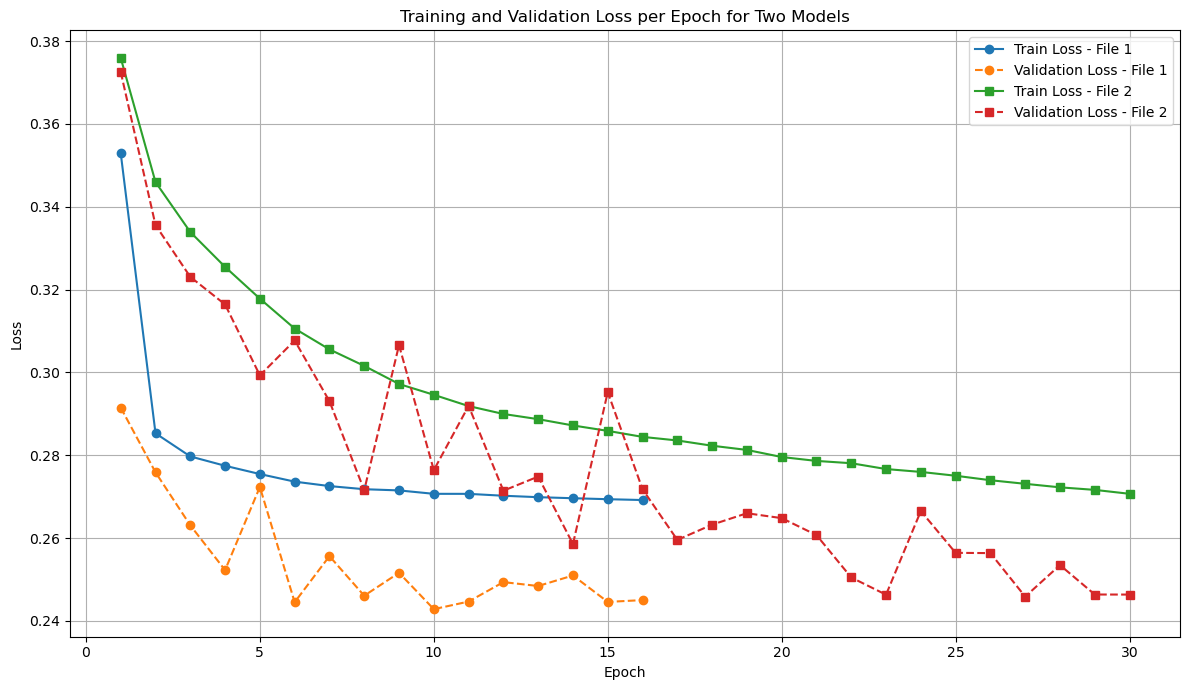

In [14]:
plot_metrics_two_files('./logs/sgd_reduce_on_plateau/sgd_reduce_on_plateau.csv', './logs/adam_cosine/adam_cosine.csv')

However, the first model achieved better results in much shorter times. This suggests that learning rate was too high, as it started faster and failed to converge aftervards. <br>
Here are last two epochs for the second model:
```
Epoch 29/50
----------
                                                           
Training Loss: 0.2716
                                                           
Validation Loss: 0.2464
Validation Metrics - Accuracy: 0.0120, Precision: 0.6812, Recall: 0.5255, F1 Score: 0.5502, AUC: 0.8999
Current Learning Rate: 0.000376
Elapsed Time: 333.38 seconds
No improvement in validation loss for 2 epoch(s).

Epoch 30/50
----------
                                                           
Training Loss: 0.2707
                                                           
Validation Loss: 0.2464
Validation Metrics - Accuracy: 0.0106, Precision: 0.6942, Recall: 0.4917, F1 Score: 0.5121, AUC: 0.8989
Current Learning Rate: 0.000345
Elapsed Time: 334.12 seconds
No improvement in validation loss for 3 epoch(s).
```

We can see that cosine scheduler significantly reduced learning rate from initial 0.001. It explains better learning curve.

# Something Else

Well, we have *some* results, which seems unsatisfactory to me. I will try to fix my model by introducing several significant updates to hyperparameters and architecture. This is generally not the best practice, and tuning parameters one-by-one will lead to better results, but training this model is very time-consuming (30 epochs took ~3-4 hours with RTX 4090). Now, to the updates:

In [1]:
import os
import csv
import time
import torch
import torchvision
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
BATCH_SIZE = 200
NUM_WORKERS = 8

In [3]:
# Check device
device = torch.device('cuda') if torch.cuda.is_available() else None
print(f'Using device: {device} | {torch.cuda.get_device_name()}')

Using device: cuda | NVIDIA GeForce RTX 3090


I will start by slightly modifying transformations.

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), #
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)), #
    transforms.ToTensor(),
    transforms.Normalize((0.5310, 0.4254, 0.3712),
                         (0.2981, 0.2675, 0.2618)),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5310, 0.4254, 0.3712),
                         (0.2981, 0.2675, 0.2618)),
])

In [5]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train', transform=train_transform, download=False)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test', transform=val_test_transform, download=False)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid', transform=val_test_transform, download=False)

In [6]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

As promised, I am integrating SE Blocks into my architecture. <br>
[The paper](https://openaccess.thecvf.com/content_cvpr_2018/papers/Hu_Squeeze-and-Excitation_Networks_CVPR_2018_paper.pdf) suggests the following:

![](./img/seresnet.png)


In [7]:

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        """
        Squeeze-and-Excitation (SE) block.

        Args:
            channel (int): Number of input channels.
            reduction (int): Reduction ratio for the bottleneck in SE block.
        """
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze: Global average pooling
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),  # Excitation: FC -> ReLU
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),  # Excitation: FC -> Sigmoid
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Scale
        return x * y.expand_as(x)

In [8]:
class Bottleneck(nn.Module):
    expansion = 4  # Expansion factor for output channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        """
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels before expansion
            stride (int): Stride for the convolution
            downsample (nn.Module or None): Downsampling layer to match dimensions
            reduction (int): Reduction ratio for SE block
        """
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # To match dimensions if needed
        self.stride = stride

        # SE block
        self.se = SEBlock(out_channels * self.expansion, reduction)

    def forward(self, x):
        identity = x  # Save input for residual connection

        # First convolution: dimension reduction
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second convolution: feature extraction
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Third convolution: dimension restoration
        out = self.conv3(out)
        out = self.bn3(out)

        # Apply SE block
        out = self.se(out)

        # Downsample if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Residual connection
        out += identity
        out = self.relu(out)

        return out

In [9]:
class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=40):
        """
        Args:
            block (nn.Module): Block type (we use Bottleneck)
            layers (list): Number of blocks in each of the four layers
            num_classes (int): Number of output classes
        """
        super(SEResNet, self).__init__()
        self.in_channels = 64  # Initial number of channels

        # Initial convolution and max pooling layers
        self.conv1 =   nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 =     nn.BatchNorm2d(self.in_channels)
        self.relu =    nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # The four layers of ResNet
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc =      nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Create one layer of the network consisting of multiple blocks.

        Args:
            block (nn.Module): Block type (we use Bottleneck)
            out_channels (int): Number of output channels before expansion
            blocks (int): Number of blocks in this layer
            stride (int): Stride for the first block in this layer
        """
        downsample = None
        # If the input and output dimensions differ, define a downsampling layer
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # First block in the layer may have stride and downsampling
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion  # Update in_channels for next blocks

        # Add remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """
        Initialize weights using Kaiming He initialization for convolutions
        and setting BatchNorm weights to 1 and biases to 0.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution and max pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Transform to 2D tensor
        x = self.fc(x)

        return x


In [10]:
def SEResNet50(num_classes=40):
    """
    Constructs a SE-ResNet-50 model.

    Args:
        num_classes (int): Number of output classes

    Returns:
        ResNet: SE-ResNet-50 model instance
    """
    return SEResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

In [11]:
# Instantiate the model
model = SEResNet50(num_classes=40).to(device)

# Print model architecture
print(model)
print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')


SEResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [12]:
# Define paths for checkpoints and logs
CHECKPOINT_PATH = 'checkpoints'
LOG_PATH = 'training_log.csv'
FULL_MODEL_PATH = 'resnet50_full_model.pth'

# Training and early stopping
NUM_EPOCHS = 50
PATIENCE = 10

# Variables for training
best_val_loss = float('inf')
epochs_no_improve = 0
start_epoch = 0

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Initialize logging
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, mode='w', newline='') as log_file:
        log_writer = csv.writer(log_file)
        log_writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Learning Rate', 'Elapsed Time'])

I am now using a new scheduler and optimizer, once more. I have made a mistake with OneCycleLR and got another training log with constant LR (i have been stepping scheduler on each epoch instead of each batch). We will compare the two later.

Looks like using weighted loss made the greatest effect, though.

In [13]:
# Calculate class weights based on training data
class_counts = train_dataset.attr.sum(dim=0)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize

criterion = nn.BCEWithLogitsLoss(weight=class_weights.to(device))

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,              # Initial learning rate
    weight_decay=1e-2     
)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,                  # Maximum learning rate
    total_steps=NUM_EPOCHS * len(train_loader),
    pct_start=0.3,               
    anneal_strategy='cos',        # Cosine annealing
    cycle_momentum=False,         
    div_factor=25,               
    final_div_factor=1e4          
)


In [14]:
def calculate_metrics(outputs, targets):
    # Apply sigmoid to outputs
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

    # Move to CPU and convert to numpy
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    probs = probs.cpu().detach().numpy()

    # Calculate metrics for multi-label classification
    accuracy = metrics.accuracy_score(targets, preds)
    precision = metrics.precision_score(targets, preds, average='macro', zero_division=0)
    recall = metrics.recall_score(targets, preds, average='macro', zero_division=0)
    f1 = metrics.f1_score(targets, preds, average='macro', zero_division=0)
    # AUC requires at least one positive and one negative sample per class
    try:
        auc = metrics.roc_auc_score(targets, probs, average='macro')
    except ValueError:
        auc = float('nan')

    return accuracy, precision, recall, f1, auc

In [15]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    return start_epoch, best_val_loss

In [16]:
# Check if a checkpoint exists
latest_checkpoint = None
if os.listdir(CHECKPOINT_PATH):
    checkpoints = sorted([ckpt for ckpt in os.listdir(CHECKPOINT_PATH) if ckpt.endswith('.pth')], key=lambda x: os.path.getmtime(os.path.join(CHECKPOINT_PATH, x)))
    latest_checkpoint = os.path.join(CHECKPOINT_PATH, checkpoints[-1])

if latest_checkpoint:
    print(f"Loading checkpoint from {latest_checkpoint}")
    start_epoch, best_val_loss = load_checkpoint(latest_checkpoint)
    print(f"Resuming from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

No checkpoint found. Starting training from scratch.


In [17]:
def train(model, dataloader, criterion, optimizer, device, scheduler):
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        targets = targets.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Step the scheduler after each optimizer step
        # Needed for OneCycleLR
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        all_outputs.append(outputs)
        all_targets.append(targets)

    epoch_loss = running_loss / len(dataloader.dataset)
    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    return epoch_loss, all_outputs, all_targets

In [18]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            targets = targets.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            all_outputs.append(outputs)
            all_targets.append(targets)

    epoch_loss = running_loss / len(dataloader.dataset)
    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    return epoch_loss, all_outputs, all_targets

In [19]:
# Main training loop
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 10)
    epoch_start_time = time.time()

    # Training phase
    train_loss, train_outputs, train_targets = train(model, train_loader, criterion, optimizer, device, scheduler)
    print(f"Training Loss: {train_loss:.4f}")

    # Validation phase
    val_loss, val_outputs, val_targets = validate(model, valid_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")

    # Calculate metrics
    accuracy, precision, recall, f1, auc = calculate_metrics(val_outputs, val_targets)
    print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

    # Step the scheduler
    # Not needed here anymore
    # scheduler.step()

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f"Current Learning Rate: {current_lr:.6f}")

    # Calculate elapsed time
    elapsed_time = time.time() - epoch_start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    # Log to CSV
    with open(LOG_PATH, mode='a', newline='') as log_file:
        log_writer = csv.writer(log_file)
        log_writer.writerow([epoch + 1, train_loss, val_loss, accuracy, precision, recall, f1, auc, current_lr, elapsed_time])

    # Checkpointing: Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        checkpoint_filename = os.path.join(CHECKPOINT_PATH, f'checkpoint_epoch_{epoch + 1}.pth')
        save_checkpoint({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_filename)
        print("Best model updated and checkpoint saved.\n")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).\n")

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
        break

# Save the full model after successful training
torch.save(model, FULL_MODEL_PATH)
print(f"Full model saved to {FULL_MODEL_PATH}")


Epoch 1/50
----------


Training Loss: 0.2645


Validation Loss: 0.2159
Validation Metrics - Accuracy: 0.0026, Precision: 0.5972, Recall: 0.3257, F1 Score: 0.3456, AUC: 0.8074
Current Learning Rate: 0.000050
Elapsed Time: 402.92 seconds
Best model updated and checkpoint saved.

Epoch 2/50
----------


Training Loss: 0.2135


Validation Loss: 0.1752
Validation Metrics - Accuracy: 0.0060, Precision: 0.6881, Recall: 0.4678, F1 Score: 0.4958, AUC: 0.8829
Current Learning Rate: 0.000082
Elapsed Time: 402.80 seconds
Best model updated and checkpoint saved.

Epoch 3/50
----------


Training Loss: 0.1898


Validation Loss: 0.1581
Validation Metrics - Accuracy: 0.0103, Precision: 0.7602, Recall: 0.4585, F1 Score: 0.5170, AUC: 0.9032
Current Learning Rate: 0.000132
Elapsed Time: 403.05 seconds
Best model updated and checkpoint saved.

Epoch 4/50
----------


Training Loss: 0.1782


Validation Loss: 0.1512
Validation Metrics - Accuracy: 0.0113, Precision: 0.7415, Recall: 0.5443, F1 Score: 0.5916, AUC: 0.9128
Current Learning Rate: 0.000199
Elapsed Time: 403.18 seconds
Best model updated and checkpoint saved.

Epoch 5/50
----------


Training Loss: 0.1718


Validation Loss: 0.1502
Validation Metrics - Accuracy: 0.0146, Precision: 0.7687, Recall: 0.5354, F1 Score: 0.5873, AUC: 0.9186
Current Learning Rate: 0.000280
Elapsed Time: 402.79 seconds
Best model updated and checkpoint saved.

Epoch 6/50
----------


Training Loss: 0.1672


Validation Loss: 0.1509
Validation Metrics - Accuracy: 0.0112, Precision: 0.7718, Recall: 0.5317, F1 Score: 0.5757, AUC: 0.9188
Current Learning Rate: 0.000372
Elapsed Time: 402.96 seconds
No improvement in validation loss for 1 epoch(s).

Epoch 7/50
----------


Training Loss: 0.1640


Validation Loss: 0.1473
Validation Metrics - Accuracy: 0.0133, Precision: 0.7158, Recall: 0.6236, F1 Score: 0.6313, AUC: 0.9240
Current Learning Rate: 0.000470
Elapsed Time: 403.47 seconds
Best model updated and checkpoint saved.

Epoch 8/50
----------


Training Loss: 0.1612


Validation Loss: 0.1399
Validation Metrics - Accuracy: 0.0195, Precision: 0.7600, Recall: 0.5642, F1 Score: 0.6146, AUC: 0.9271
Current Learning Rate: 0.000570
Elapsed Time: 402.78 seconds
Best model updated and checkpoint saved.

Epoch 9/50
----------


Training Loss: 0.1588


Validation Loss: 0.1467
Validation Metrics - Accuracy: 0.0153, Precision: 0.7384, Recall: 0.6121, F1 Score: 0.6280, AUC: 0.9250
Current Learning Rate: 0.000668
Elapsed Time: 402.73 seconds
No improvement in validation loss for 1 epoch(s).

Epoch 10/50
----------


Training Loss: 0.1566


Validation Loss: 0.1419
Validation Metrics - Accuracy: 0.0172, Precision: 0.7590, Recall: 0.5907, F1 Score: 0.6273, AUC: 0.9295
Current Learning Rate: 0.000760
Elapsed Time: 402.72 seconds
No improvement in validation loss for 2 epoch(s).

Epoch 11/50
----------


Training Loss: 0.1551


Validation Loss: 0.1411
Validation Metrics - Accuracy: 0.0156, Precision: 0.7295, Recall: 0.6475, F1 Score: 0.6606, AUC: 0.9296
Current Learning Rate: 0.000841
Elapsed Time: 403.24 seconds
No improvement in validation loss for 3 epoch(s).

Epoch 12/50
----------


Training Loss: 0.1530


Validation Loss: 0.1396
Validation Metrics - Accuracy: 0.0171, Precision: 0.7296, Recall: 0.6580, F1 Score: 0.6703, AUC: 0.9293
Current Learning Rate: 0.000908
Elapsed Time: 402.98 seconds
Best model updated and checkpoint saved.

Epoch 13/50
----------


Training Loss: 0.1514


Validation Loss: 0.1339
Validation Metrics - Accuracy: 0.0185, Precision: 0.7382, Recall: 0.6488, F1 Score: 0.6670, AUC: 0.9319
Current Learning Rate: 0.000959
Elapsed Time: 402.70 seconds
Best model updated and checkpoint saved.

Epoch 14/50
----------


Training Loss: 0.1498


Validation Loss: 0.1321
Validation Metrics - Accuracy: 0.0213, Precision: 0.7542, Recall: 0.6487, F1 Score: 0.6712, AUC: 0.9342
Current Learning Rate: 0.000990
Elapsed Time: 403.07 seconds
Best model updated and checkpoint saved.

Epoch 15/50
----------


Training Loss: 0.1482


Validation Loss: 0.1298
Validation Metrics - Accuracy: 0.0214, Precision: 0.7558, Recall: 0.6557, F1 Score: 0.6799, AUC: 0.9346
Current Learning Rate: 0.001000
Elapsed Time: 403.26 seconds
Best model updated and checkpoint saved.

Epoch 16/50
----------


Training Loss: 0.1465


Validation Loss: 0.1302
Validation Metrics - Accuracy: 0.0199, Precision: 0.7534, Recall: 0.6559, F1 Score: 0.6792, AUC: 0.9362
Current Learning Rate: 0.000998
Elapsed Time: 402.99 seconds
No improvement in validation loss for 1 epoch(s).

Epoch 17/50
----------


Training Loss: 0.1448


Validation Loss: 0.1319
Validation Metrics - Accuracy: 0.0200, Precision: 0.7552, Recall: 0.6511, F1 Score: 0.6757, AUC: 0.9344
Current Learning Rate: 0.000992
Elapsed Time: 403.57 seconds
No improvement in validation loss for 2 epoch(s).

Epoch 18/50
----------


Training Loss: 0.1434


Validation Loss: 0.1229
Validation Metrics - Accuracy: 0.0254, Precision: 0.7751, Recall: 0.6518, F1 Score: 0.6921, AUC: 0.9389
Current Learning Rate: 0.000982
Elapsed Time: 403.35 seconds
Best model updated and checkpoint saved.

Epoch 19/50
----------


Training Loss: 0.1423


Validation Loss: 0.1267
Validation Metrics - Accuracy: 0.0238, Precision: 0.7361, Recall: 0.7027, F1 Score: 0.7053, AUC: 0.9383
Current Learning Rate: 0.000968
Elapsed Time: 402.72 seconds
No improvement in validation loss for 1 epoch(s).

Epoch 20/50
----------


Training Loss: 0.1409


Validation Loss: 0.1279
Validation Metrics - Accuracy: 0.0232, Precision: 0.7594, Recall: 0.6717, F1 Score: 0.6921, AUC: 0.9387
Current Learning Rate: 0.000950
Elapsed Time: 403.84 seconds
No improvement in validation loss for 2 epoch(s).

Epoch 21/50
----------


Training Loss: 0.1396


Validation Loss: 0.1257
Validation Metrics - Accuracy: 0.0237, Precision: 0.7617, Recall: 0.6674, F1 Score: 0.6903, AUC: 0.9387
Current Learning Rate: 0.000929
Elapsed Time: 403.34 seconds
No improvement in validation loss for 3 epoch(s).

Epoch 22/50
----------


Training Loss: 0.1386


Validation Loss: 0.1251
Validation Metrics - Accuracy: 0.0247, Precision: 0.7703, Recall: 0.6544, F1 Score: 0.6865, AUC: 0.9398
Current Learning Rate: 0.000904
Elapsed Time: 402.78 seconds
No improvement in validation loss for 4 epoch(s).

Epoch 23/50
----------


Training Loss: 0.1375


Validation Loss: 0.1246
Validation Metrics - Accuracy: 0.0258, Precision: 0.7591, Recall: 0.6728, F1 Score: 0.6962, AUC: 0.9399
Current Learning Rate: 0.000876
Elapsed Time: 403.11 seconds
No improvement in validation loss for 5 epoch(s).

Epoch 24/50
----------


Training Loss: 0.1365


Validation Loss: 0.1244
Validation Metrics - Accuracy: 0.0268, Precision: 0.7529, Recall: 0.6842, F1 Score: 0.7018, AUC: 0.9398
Current Learning Rate: 0.000845
Elapsed Time: 403.50 seconds
No improvement in validation loss for 6 epoch(s).

Epoch 25/50
----------


KeyboardInterrupt: 

The training process takes too much time, and I'm interrupting it on 25th epoch. <br>
Current metrics are:

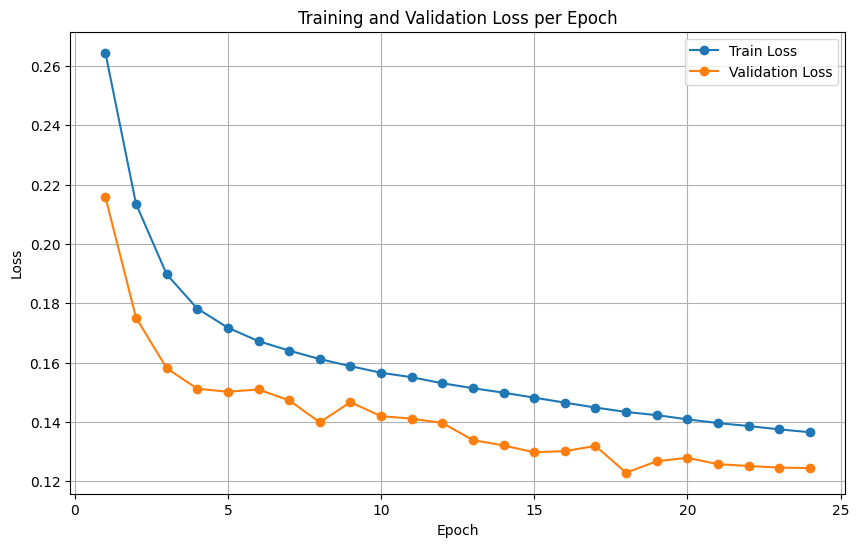

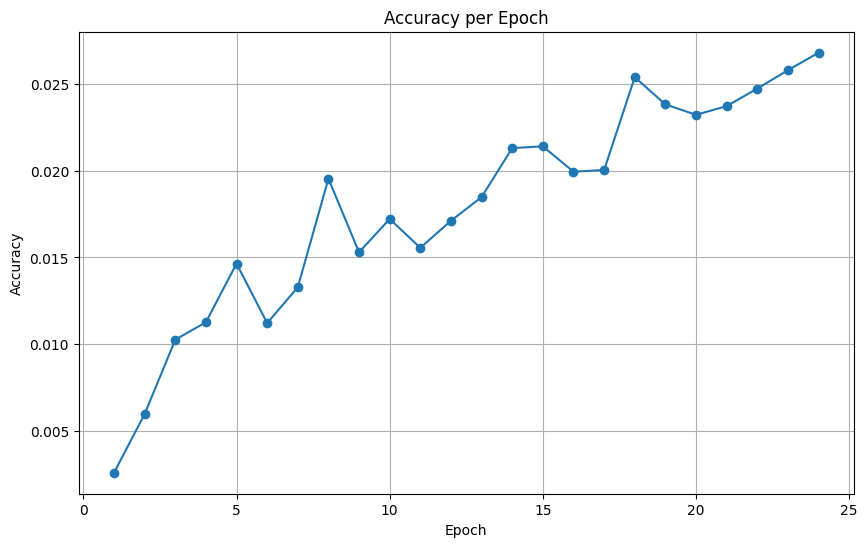

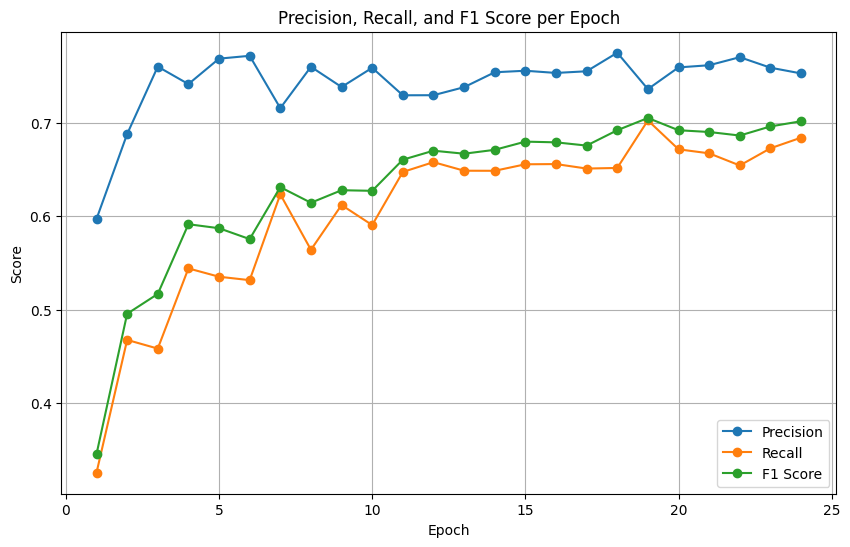

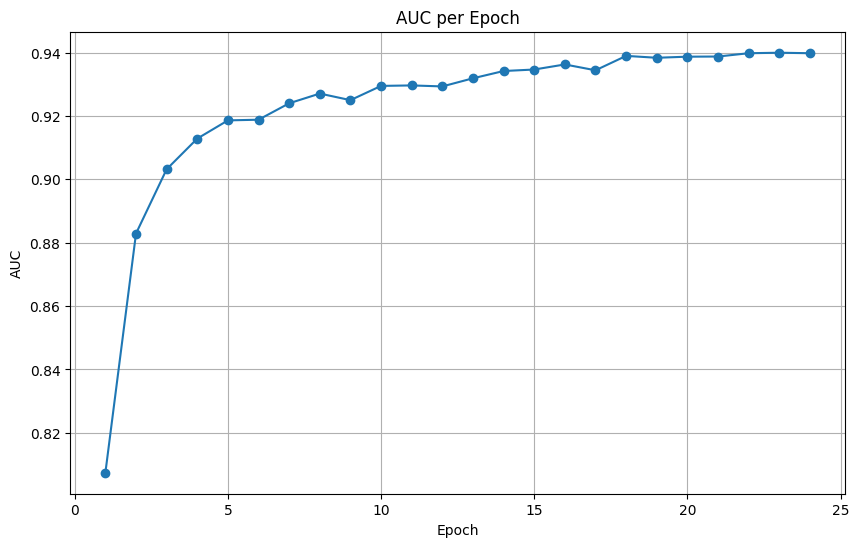

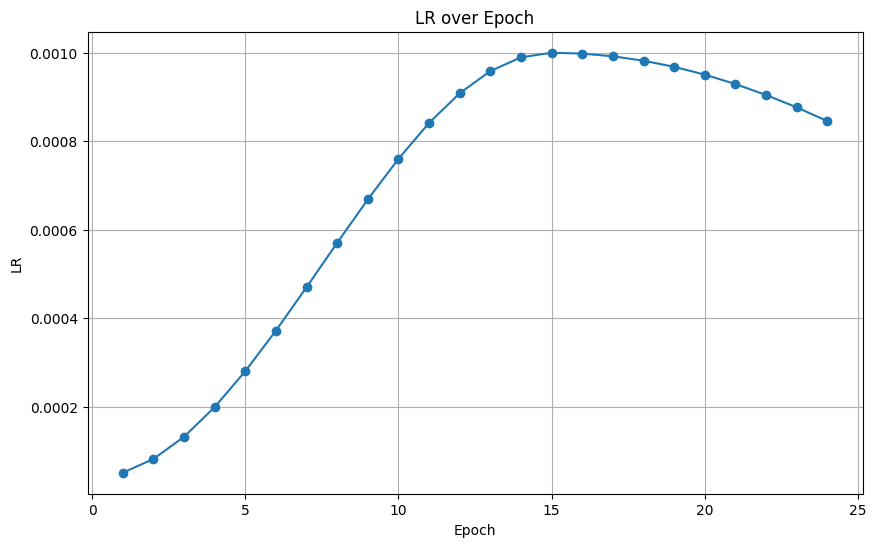

In [20]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_metrics(file_path: str):
    training_log_df = pd.read_csv(file_path)

    epochs = training_log_df['Epoch']
    train_loss = training_log_df['Train Loss']
    val_loss = training_log_df['Val Loss']
    accuracy = training_log_df['Accuracy']
    precision = training_log_df['Precision']
    recall = training_log_df['Recall']
    f1_score = training_log_df['F1 Score']
    auc = training_log_df['AUC']
    lr = training_log_df['Learning Rate']


    # Plot Train Loss and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy, label='Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.grid()
    plt.show()

    # Plot Precision, Recall, and F1 Score
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, precision, label='Precision', marker='o')
    plt.plot(epochs, recall, label='Recall', marker='o')
    plt.plot(epochs, f1_score, label='F1 Score', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score per Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot AUC
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, auc, label='AUC', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC per Epoch')
    plt.grid()
    plt.show()

    # Plot LR
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, lr, label='LR', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.title('LR over Epoch')
    plt.grid()
    plt.show()

plot_metrics('training_log.csv')

We can observe much better learning curve and final characteristics. I will now compare it to my failed attempt with constant LR:

In [1]:
def plot_metrics_two_files(file_path1: str, file_path2: str, label1: str = 'File 1', label2: str = 'File 2'):
    training_log_df1 = pd.read_csv(file_path1)
    training_log_df2 = pd.read_csv(file_path2)

    epochs1 = training_log_df1['Epoch']
    train_loss1 = training_log_df1['Train Loss']
    val_loss1 = training_log_df1['Val Loss']
    
    epochs2 = training_log_df2['Epoch']
    train_loss2 = training_log_df2['Train Loss']
    val_loss2 = training_log_df2['Val Loss']
    
    plt.figure(figsize=(12, 7))
    
    # File 1 - Train Loss
    plt.plot(epochs1, train_loss1, label=f'Train Loss - {label1}', marker='o', linestyle='-')
    
    # File 1 - Validation Loss
    plt.plot(epochs1, val_loss1, label=f'Validation Loss - {label1}', marker='o', linestyle='--')
    
    # File 2 - Train Loss
    plt.plot(epochs2, train_loss2, label=f'Train Loss - {label2}', marker='s', linestyle='-')
    
    # File 2 - Validation Loss
    plt.plot(epochs2, val_loss2, label=f'Validation Loss - {label2}', marker='s', linestyle='--')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch for Two Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

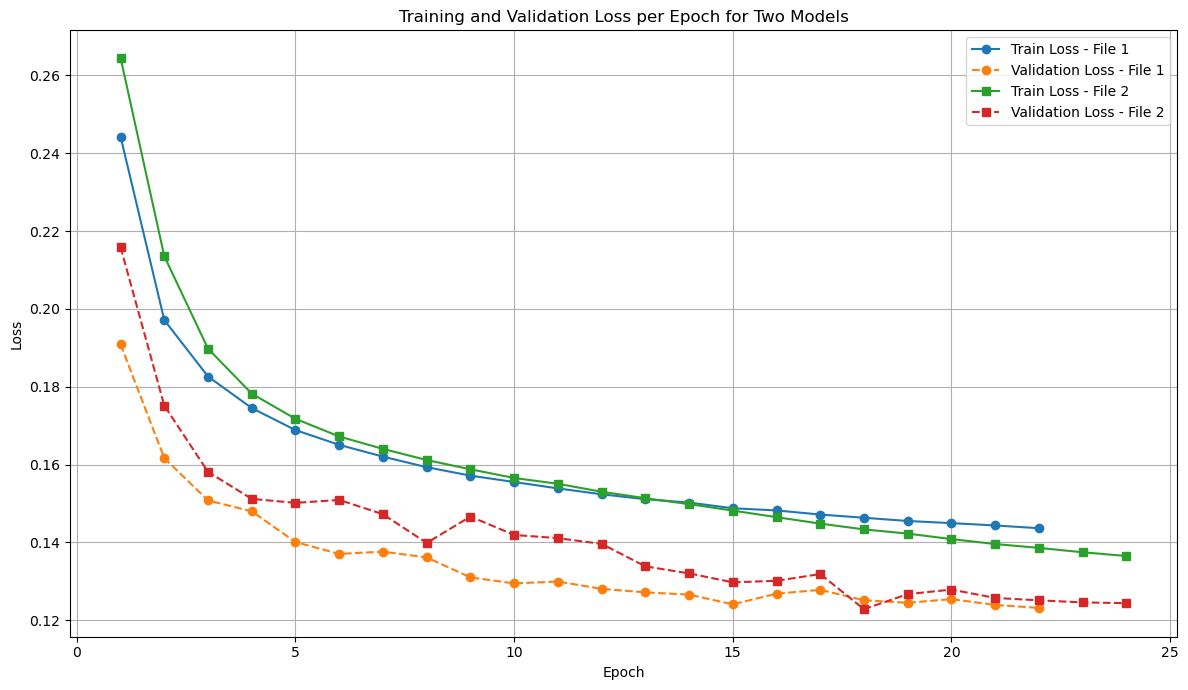

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

plot_metrics_two_files('./logs/adamw_const/adamw_const.csv', './logs/adamw_one_cycle/adamw_one_cycle.csv')

We can see that LR scheduler helped with faster convergense, however both are struggling to get better after 20th epoch.

## Evaluation

I will now visualise model's achievements. 18th epoch checkpoint is used as the one with best validation loss.

In [21]:
import os
import torch

CHECKPOINT_PATH = 'checkpoints'
CHECKPOINT_FILENAME = 'checkpoint_epoch_18.pth'
checkpoint_file = os.path.join(CHECKPOINT_PATH, CHECKPOINT_FILENAME)

if not os.path.exists(checkpoint_file):
    raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_file}")

checkpoint = torch.load(checkpoint_file, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() 
print(f"Loaded checkpoint from {checkpoint_file} (Epoch {checkpoint['epoch'] + 1})")


/tmp/ipykernel_7227/2986136931.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=device)


Loaded checkpoint from checkpoints/checkpoint_epoch_18.pth (Epoch 18)


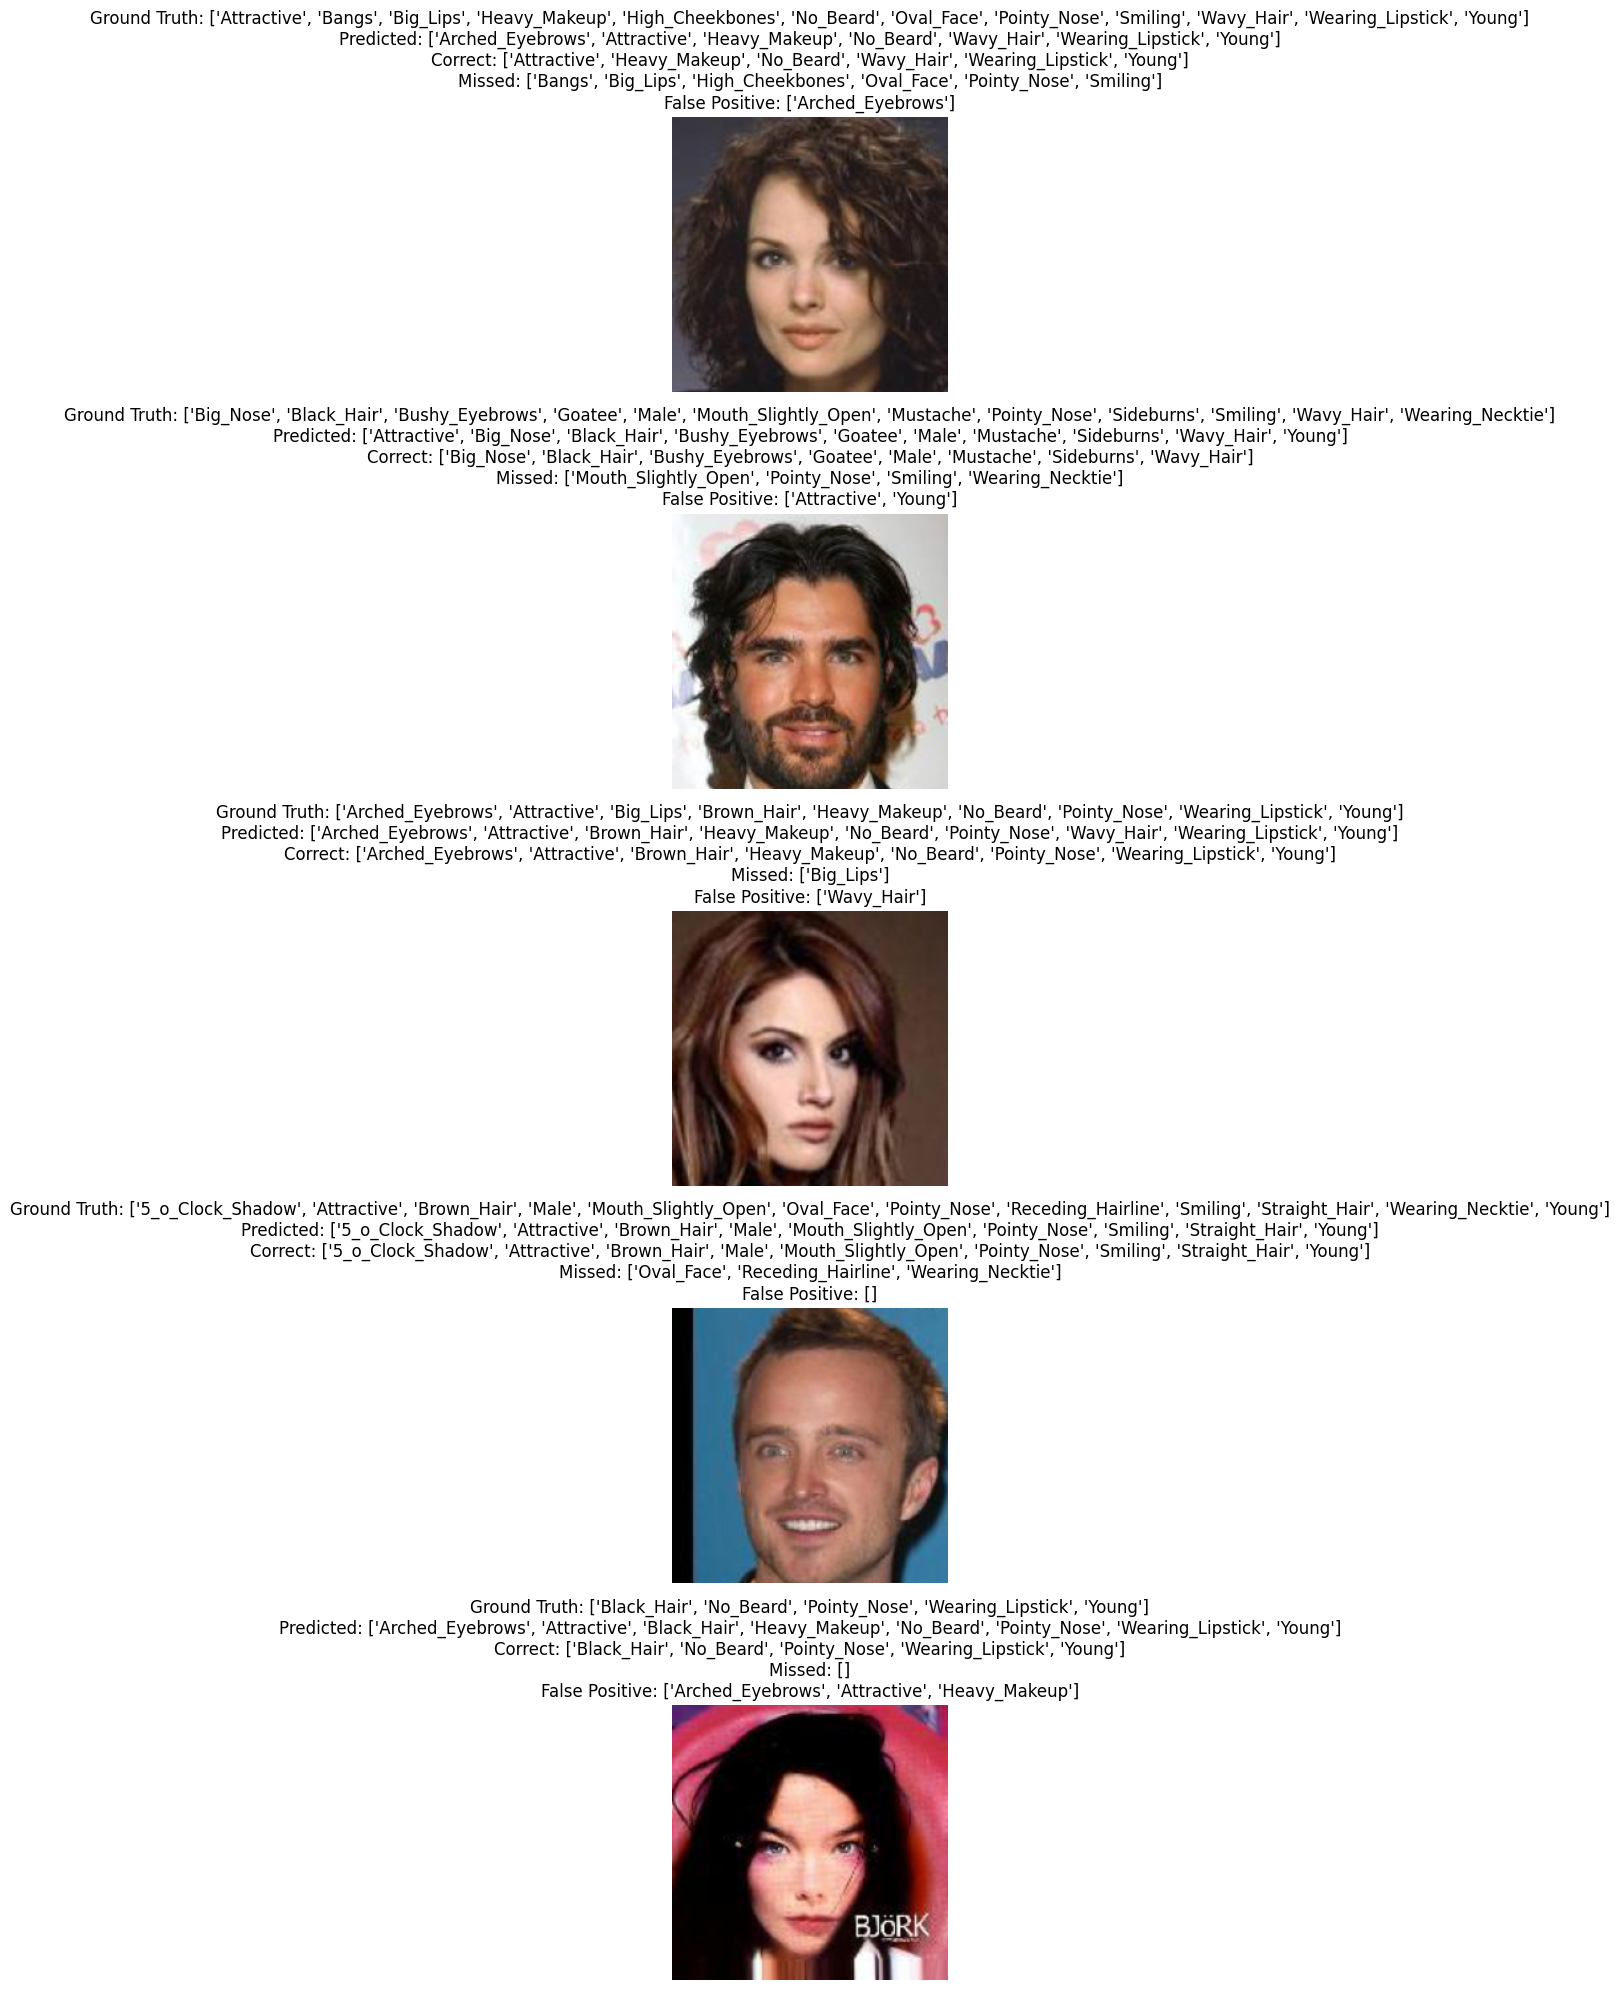

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch

NUM_SAMPLES = 5

attribute_names = train_dataset.attr_names

def visualize_detailed_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, num_samples * 4))  # Increased height for more text

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                # Denormalize the image
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = np.clip(img * np.array([0.2981, 0.2675, 0.2618]) + 
                              np.array([0.5310, 0.4254, 0.3712]), 0, 1)

                # Convert ground truth and predictions to numpy arrays
                gt = targets[i].cpu().numpy().astype(int)
                pred = preds[i].cpu().numpy().astype(int)

                # Determine Correct, Missed, and False Positive attributes
                correct = (gt & pred).astype(int)
                missed = (gt & ~pred).astype(int)
                false_positive = (~gt & pred).astype(int)

                # Extract attribute names for each category
                gt_attrs = [attribute_names[j] for j in range(len(gt)) if gt[j] == 1]
                pred_attrs = [attribute_names[j] for j in range(len(pred)) if pred[j] == 1]
                correct_attrs = [attribute_names[j] for j in range(len(correct)) if correct[j] == 1]
                missed_attrs = [attribute_names[j] for j in range(len(missed)) if missed[j] == 1]
                false_positive_attrs = [attribute_names[j] for j in range(len(false_positive)) if false_positive[j] == 1]

                # Create the subplot
                plt.subplot(num_samples, 1, images_shown + 1)
                plt.imshow(img)
                plt.axis('off')

                # Create a detailed title
                title = (
                    f"Ground Truth: {gt_attrs}\n"
                    f"Predicted: {pred_attrs}\n"
                    f"Correct: {correct_attrs}\n"
                    f"Missed: {missed_attrs}\n"
                    f"False Positive: {false_positive_attrs}"
                )
                plt.title(title, fontsize=12)

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

visualize_detailed_predictions(model, valid_loader, device, num_samples=NUM_SAMPLES)


And now we can see why the metrics may not be as good as expected: to me, some ground truth labels seem.. unreasonable. <br>
In general, the model still does pretty good job in identifying some of the attributes anyways.

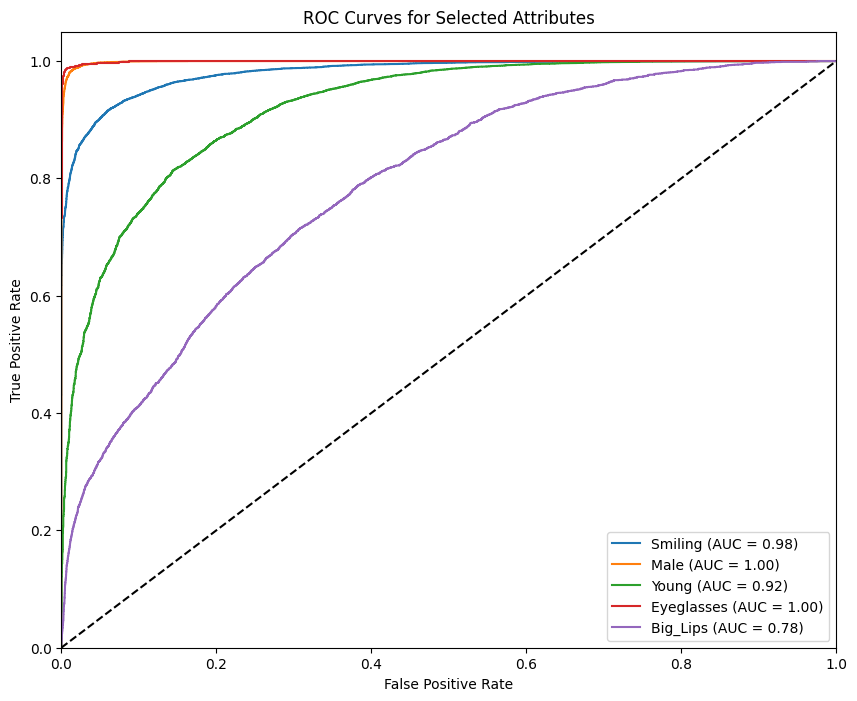

In [27]:
from sklearn.metrics import roc_curve, auc

# A subset of attributes to plot ROC curves
selected_attributes = ['Smiling', 'Male', 'Young', 'Eyeglasses', 'Big_Lips']

def plot_roc_curves(model, dataloader, device, attributes):
    model.eval()
    all_targets = {attr: [] for attr in attributes}
    all_probs = {attr: [] for attr in attributes}
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            
            for i, attr in enumerate(attribute_names[:40]):
                if attr in attributes:
                    all_targets[attr].extend(targets[:, i].cpu().numpy())
                    all_probs[attr].extend(probs[:, i].cpu().numpy())
    
    plt.figure(figsize=(10, 8))
    
    for attr in attributes:
        fpr, tpr, _ = roc_curve(all_targets[attr], all_probs[attr])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{attr} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Selected Attributes')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curves(model, valid_loader, device, selected_attributes)


Here we can see that some attributes are much more obvious than the others. 

## Outro

That was a fun journey for me, as I explored multiple architectures, schedulers, optimisers and many more. <br>
I had really good time waiting for the things to train in cafes and subway.. <br>
Anyway, the project folder is now like 14 GB total with all checkpoints, so I will probably only publish the notebook, however I would without hesitation provide any additional info and materials on the first notice, if any questions arise. <br>
I am grateful for providing this task, as it really got the brain going :)